# Clustering to uncovering voting blocs

**Input:** Feature matrix from Step 2 — 197 countries × 6 values (YES-rate per issue category)  

Steps:
1. Standardize features (z-score so no issue dominates by scale)
2. Run k-means with k=4
3. PCA projection to 2D for visualization
4. Interpret cluster profiles
5. Save results

## 1. Load & Standardize

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

PIPELINE = Path('/Users/kerematas/Desktop/database/un-votes/pipeline')

with open(PIPELINE / 'sql_results.pkl', 'rb') as f:
    sql = pickle.load(f)

fm = sql['q3_feature_matrix'].copy()
issue_cols = [c for c in fm.columns if c.startswith('yes_pct_')]

ISSUE_NAMES = {
    'yes_pct_ME': 'Middle East',
    'yes_pct_NU': 'Nuclear',
    'yes_pct_DI': 'Disarmament',
    'yes_pct_HR': 'Human Rights',
    'yes_pct_CO': 'Colonialism',
    'yes_pct_EC': 'Economic Dev.',
}

X_raw = fm[issue_cols].values
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

print(f'Feature matrix: {X.shape[0]} countries × {X.shape[1]} features')
pd.DataFrame(X, columns=issue_cols, index=fm['country_id']).head(8)

## 2. K-Means Clustering (k=4)

In [4]:
K = 4

km_final = KMeans(n_clusters=K, random_state=42, n_init=20)
fm['cluster'] = km_final.fit_predict(X)

print(f'Cluster sizes (k={K}):')
print(fm['cluster'].value_counts().sort_index().to_string())

Cluster sizes (k=4):
cluster
0    79
1    57
2    48
3    13


## 3. PCA — Project to 2D

In [5]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X)
fm['pca_x'] = coords[:, 0]
fm['pca_y'] = coords[:, 1]

var_explained = pca.explained_variance_ratio_
print(f'PCA variance explained: PC1={var_explained[0]:.1%}  PC2={var_explained[1]:.1%}  total={sum(var_explained):.1%}')

PCA variance explained: PC1=87.3%  PC2=8.5%  total=95.8%


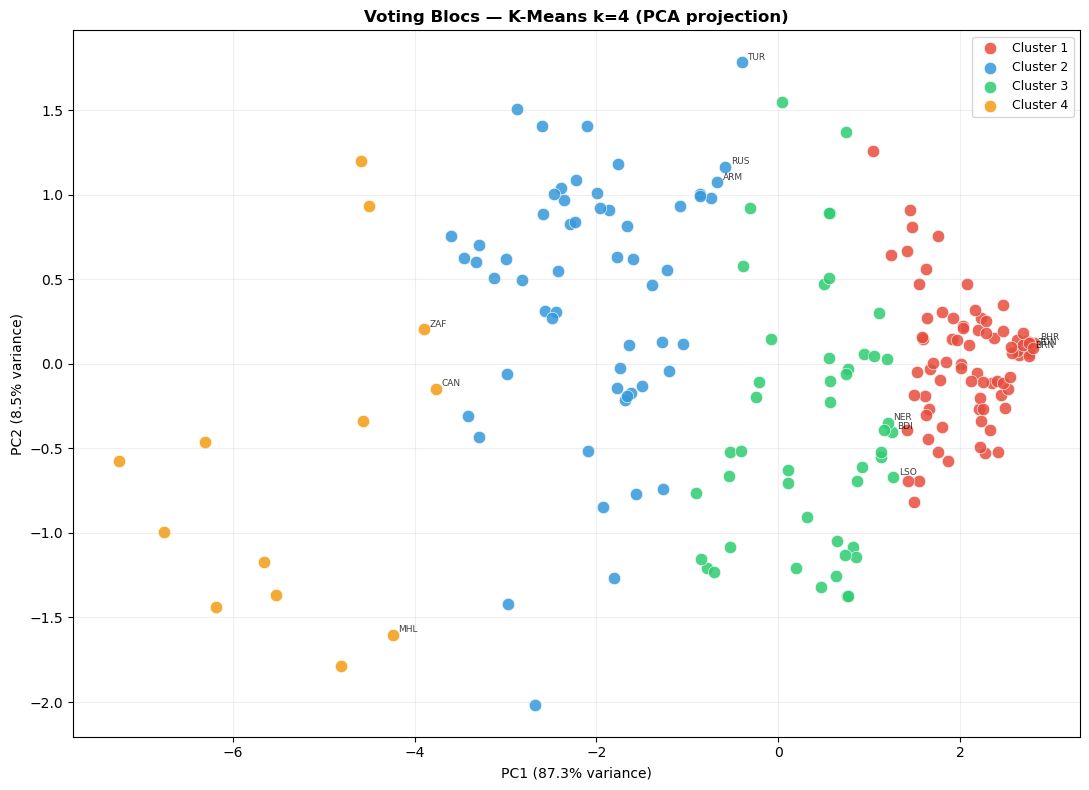

In [6]:
CLUSTER_COLORS = [
    '#e74c3c','#3498db','#2ecc71','#f39c12','#9b59b6',
    '#1abc9c','#e67e22','#34495e','#e91e63','#00bcd4','#8bc34a','#ff5722'
]

fig, ax = plt.subplots(figsize=(11, 8))

for c in range(K):
    mask = fm['cluster'] == c
    ax.scatter(
        fm.loc[mask, 'pca_x'], fm.loc[mask, 'pca_y'],
        color=CLUSTER_COLORS[c], label=f'Cluster {c+1}',
        s=80, alpha=0.85, edgecolors='white', linewidths=0.5
    )
    # Label a few notable countries per cluster
    notable = fm[mask].nlargest(3, 'pca_x')[['pca_x','pca_y','country_id']]
    for _, row in notable.iterrows():
        ax.annotate(row['country_id'], (row['pca_x'], row['pca_y']),
                    fontsize=6.5, alpha=0.75,
                    xytext=(4, 2), textcoords='offset points')

ax.set_xlabel(f'PC1 ({var_explained[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({var_explained[1]:.1%} variance)')
ax.set_title(f'Voting Blocs — K-Means k={K} (PCA projection)', fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(PIPELINE / 'cluster_pca.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Cluster Profiles — What Does Each Bloc Stand For?

In [ ]:
# Mean YES-rate per issue per cluster
profile = (
    fm.groupby('cluster')[issue_cols]
    .mean()
    .rename(columns=ISSUE_NAMES)
    .round(1)
)
profile.index = [f'Cluster {i+1}' for i in profile.index]

print('Mean YES-rate per issue per cluster:')
profile

Mean YES-rate per issue per cluster:


,Colonialism,Disarmament,Economic Dev.,Human Rights,Middle East,Nuclear
Cluster 1,90.4,89.7,88.7,80.8,91.7,91.1
Cluster 2,61.0,58.4,61.8,51.0,66.1,51.1
Cluster 3,76.4,80.0,79.0,70.1,70.9,78.7
Cluster 4,30.7,39.4,42.3,34.1,23.0,33.2


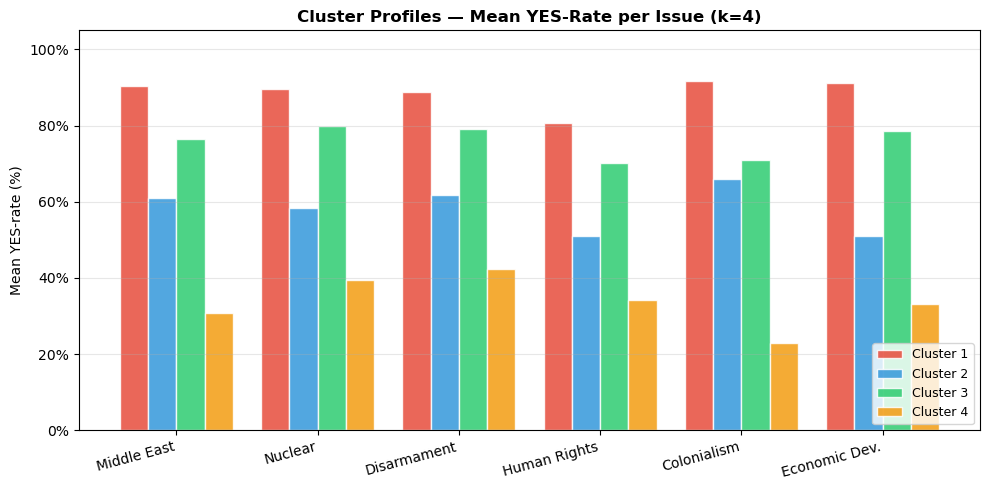

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

x     = np.arange(len(issue_cols))
width = 0.8 / K

for i in range(K):
    offset = (i - K/2 + 0.5) * width
    vals   = profile.iloc[i].values
    bars   = ax.bar(x + offset, vals, width, label=f'Cluster {i+1}',
                    color=CLUSTER_COLORS[i], alpha=0.85, edgecolor='white')

ax.set_xticks(x)
ax.set_xticklabels(list(ISSUE_NAMES.values()), rotation=15, ha='right')
ax.set_ylabel('Mean YES-rate (%)')
ax.set_title(f'Cluster Profiles — Mean YES-Rate per Issue (k={K})', fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.yaxis.set_major_formatter(mticker.PercentFormatter())
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(PIPELINE / 'cluster_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Sample Countries per Cluster

In [9]:
with open('/Users/kerematas/Desktop/database/un-votes/un_votes.db', 'rb') as _:
    pass  # just confirm DB is accessible

import sqlite3
conn = sqlite3.connect('/Users/kerematas/Desktop/database/un-votes/un_votes.db')
country_names = pd.read_sql('SELECT country_id, country_name FROM countries', conn)
conn.close()

fm_named = fm.merge(country_names, on='country_id', how='left')

for c in range(K):
    members = fm_named[fm_named['cluster'] == c]['country_name'].sort_values().tolist()
    print(f'\nCluster {c+1} ({len(members)} countries):')
    print('  ' + ', '.join(members))


Cluster 1 (79 countries):
  Afghanistan, Algeria, Azerbaijan, Bahamas, Bahrain, Bangladesh, Barbados, Benin, Bhutan, Bolivia (Plurinational State of), Botswana, Brazil, Brunei Darussalam, Burkina Faso, Cabo Verde, Chile, Colombia, Cuba, Cyprus, Djibouti, Ecuador, Egypt, Eritrea, Ethiopia, German Democratic Republic, Ghana, Guinea, Guyana, India, Indonesia, Iran (Islamic Republic of), Jamaica, Jordan, Kenya, Kuwait, Lao People's Democratic Republic, Lebanon, Libya, Madagascar, Malaysia, Maldives, Mali, Mauritania, Mauritius, Mexico, Mongolia, Morocco, Mozambique, Namibia, Nepal, Nigeria, Oman, Pakistan, Panama, Peru, Philippines, Qatar, Saudi Arabia, Senegal, Sierra Leone, Singapore, Sri Lanka, Sudan, Suriname, Syrian Arab Republic, Thailand, Togo, Trinidad and Tobago, Tunisia, Uganda, United Arab Emirates, United Republic of Tanzania, Uruguay, Venezuela, Bolivarian Republic of, Viet Nam, Yemen, Yemen Arab Republic, Zambia, Zimbabwe

Cluster 2 (57 countries):
  Albania, Andorra, Armeni

## 6. Save Results

In [10]:
import json

# Save cluster assignments for Step 7 (JSON export)
cluster_out = (
    fm_named[['country_id','country_name','cluster','pca_x','pca_y'] + issue_cols]
    .copy()
)
cluster_out['cluster'] = cluster_out['cluster'].astype(int) + 1  # 1-indexed for frontend

cluster_out.to_pickle(PIPELINE / 'cluster_results.pkl')

# Also save the profile for JSON export
profile_dict = profile.reset_index().to_dict(orient='records')

summary = {
    'k': K,
    'silhouette': round(silhouette_score(X, km_final.labels_), 4),
    'pca_variance_explained': [round(float(v), 4) for v in var_explained],
    'cluster_sizes': fm['cluster'].value_counts().sort_index().to_dict(),
    'cluster_profiles': profile_dict,
}

with open(PIPELINE / 'cluster_summary.json', 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f'Saved cluster_results.pkl and cluster_summary.json')
print(f'Silhouette score for k={K}: {summary["silhouette"]}')

Saved cluster_results.pkl and cluster_summary.json
Silhouette score for k=4: 0.4039
